# POC for Genetic Algorithm WOLT

### Imports

In [1]:
import os
import pygad
import numpy as np
import pandas as pd
from IPython.display import Image, display

In [2]:
from main import get_diners_constraints
from LossFunc import loss, MUST, MUST_NOT, HUNGRY_MINUTES

In [3]:
PEOPLES = 3

In [4]:
KOSER_IDX        = 0
VEGETARIAN_IDX   = 1
GLUTEN_FREE_IDX  = 2
ALCOHOL_FREE_IDX = 3
SPICINESS_IDX    = 4
PRICE_IDX        = 5
MIN_RATINGV      = 6
HUNGRY_IDX       = 7
CUISINES_IDX     = 8
WEEKDAY_IDX      = 9

In [5]:
CONST_DIR_PATH = './diners_input_constarints/'

NO_IMAGE_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ac/No_image_available.svg/1024px-No_image_available.svg.png'

In [89]:
# load database:
total_df = pd.read_csv('./data/csv_wolt_menus_21-8-22.csv')
rest_df = pd.read_csv('./data/csv_wolt_restaurants_21-8-22.csv').set_index('name')
groups = list(total_df.groupby('rest_name'))[:10]

In [90]:
constraints = [get_diners_constraints(os.path.join(CONST_DIR_PATH, file)) for file in os.listdir(CONST_DIR_PATH)]

### helper functions:

In [91]:
def print_dish(solution, constraint, i):
    dish = solution[i]
    
    print('-' * 50)
    print(f'{dish["name"]} - {dish["price"]} ₪')
    
    if type(dish["image"]) == str:
        display(Image(url=dish["image"], width=400, height=400))
    else:
        display(Image(url=NO_IMAGE_URL, width=200, height=200))
    
    
#     rest_const, vegetarian_const, \
#     GF_const, alcohol_percentage_const, \
#     spicy_const, price_const, _ = user_inputs_to_loss_function_inputs(constraint[0], # diner1_inputs,
#                                                                       constraint[1], # diner2_inputs,
#                                                                       constraint[2], # diner3_inputs,
#                                                                       rest_df.loc[restaurant],
#                                                                       solution[0],   # meal1_df,
#                                                                       solution[0],   # meal2_df,
#                                                                       solution[0])  # meal3_df
    

    
#     print(f'vegetarian: {"✅" if  vegetarian_const[i] else f"❌"}', end=' ')
#     print(f'GF: {f"✅" if GF_const[i] else f"❌"}', end=' ')
#     print(f'spicy: {f"✅" if spicy_const[i] else f"❌"}', end=' ')
#     print(f'alcohol: {f"✅" if alcohol_percentage_const[i] else f"❌"}')
    
    
    print(f'vegetarian: {"✅" if dish["vegetarian"] == constraint[i][VEGETARIAN_IDX] else f"❌"}', end=' ')
#     print(f"({vegetarian_const[i]}/{int(dish['vegetarian'])})", end=' ')

    print(f'GF: {f"✅" if dish["GF"] == constraint[i][GLUTEN_FREE_IDX] else f"❌"}', end=' ')
#     print(f"({GF_const[i]}/{int(dish['GF'])})", end=' ')
    
    print(f'spicy: {f"✅" if dish["spicy"] == constraint[i][SPICINESS_IDX] else f"❌"}', end=' ')
#     print(f"({spicy_const[i]}/{int(dish['spicy'])})", end=' ')
    
    print(f'alcohol: {f"✅" if (dish["alcohol_percentage"] <= 0) == constraint[i][ALCOHOL_FREE_IDX] else f"❌"}')
#     print(f"({alcohol_percentage_const[i]}/{int(dish['alcohol_percentage'])})")

    print('-' * 50)


In [92]:
def user_inputs_to_loss_function_inputs(diner1_inputs, diner2_inputs, diner3_inputs, rest, meal1_df, meal2_df, meal3_df):
    """
    Converts the user inputs to the loss function inputs.
    :params diner1_inputs, diner2_inputs, diner3_inputs: user input in format of: [0 - kosher, 1 - vegetarian,
    2 - gluten free, 3 - alcohol free, 4 - prefer spicy, 5 - max price, 6 - min rating, 7 - hunger level, 8 - desired cuisines, 9 - day]
    :param rest: df with 1 row containing the restaurant
    :param meal1_df: df with 1 row containing 1st meal
    :param meal2_df: df with 1 row containing 2nd meal
    :param meal3_df: df with 1 row containing 3rd meal
    :return: a list of inputs for the loss function - [O, M, K, DT, D, RD, R, C, V1, V2, V3, G1, G2, G3, A1, A2, A3, S1, S2, S3, PH1, PH2, PH3, PS1, PS2, PS3]
    """
    kosher1, vegetarian1, gluten_free1, alcohol_free1, spicy1, max_price1, rating1, hungry1, cuisines1, weekday = diner1_inputs
    kosher2, vegetarian2, gluten_free2, alcohol_free2, spicy2, max_price2, rating2, hungry2, cuisines2, weekday = diner2_inputs
    kosher3, vegetarian3, gluten_free3, alcohol_free3, spicy3, max_price3, rating3, hungry3, cuisines3, weekday = diner3_inputs

    # Group constraints:
    diners_kosher = False if (kosher1 == 0 and kosher2 == 0 and kosher3 == 0) else True
    diners_avg_rating = np.mean((rating1, rating2, rating3))
    hungry_diners = True if np.sum((hungry1, hungry2, hungry3)) >= 2 else False
    rest_cuisines = rest['food categories'].split('---')
    diner1_cui = 1 if len([meal for meal in cuisines1 if meal in rest_cuisines]) > 0 else 0
    diner2_cui = 1 if len([meal for meal in cuisines2 if meal in rest_cuisines]) > 0 else 0
    diner3_cui = 1 if len([meal for meal in cuisines3 if meal in rest_cuisines]) > 0 else 0

    O = 1 if weekday in rest['opening days'] else 0
    M = 1 if ((meal1_df['price'] + meal2_df['price'] + meal3_df['price']) >= 100) else 0  # TODO replace with order min
    K = 0 if diners_kosher and not rest['kosher'] else 1
    DT = rest['delivery estimation [minutes]'] + rest['prep estimation [minutes]']
    D = 0 if (hungry_diners and rest['delivery estimation [minutes]'] + rest['prep estimation [minutes]'] >= HUNGRY_MINUTES) else 1
    RD = rest['rating'] - diners_avg_rating
    R = 1 if diners_avg_rating <= rest['rating'] else 0
    C = diner1_cui + diner2_cui + diner3_cui

    # individual constraints:
    diner_delivery_cost = + rest['delivery price'] / 3
    price1, price2, price3 = meal1_df['price'], meal2_df['price'], meal3_df['price']

    V1 = 0 if vegetarian1 == MUST and not meal1_df['vegetarian'] else 1
    V2 = 0 if vegetarian2 == MUST and not meal2_df['vegetarian'] else 1
    V3 = 0 if vegetarian3 == MUST and not meal3_df['vegetarian'] else 1
    
    G1 = 0 if gluten_free1 == MUST and not meal1_df['GF'] else 1
    G2 = 0 if gluten_free2 == MUST and not meal2_df['GF'] else 1
    G3 = 0 if gluten_free3 == MUST and not meal3_df['GF'] else 1
    
    A1 = 0 if alcohol_free1 == MUST and meal1_df['alcohol_percentage'] > 0 else 1
    A2 = 0 if alcohol_free2 == MUST and meal2_df['alcohol_percentage'] > 0 else 1
    A3 = 0 if alcohol_free3 == MUST and meal3_df['alcohol_percentage'] > 0 else 1
    
    spicy_meal1, spicy_meal2, spicy_meal3 = meal1_df['spicy'], meal2_df['spicy'], meal3_df['spicy']
    
    S1 = 0 if (spicy1 == MUST and not spicy_meal1) or (spicy1 == MUST_NOT and spicy_meal1) else 1
    S2 = 0 if (spicy2 == MUST and not spicy_meal2) or (spicy2 == MUST_NOT and spicy_meal2) else 1
    S3 = 0 if (spicy3 == MUST and not spicy_meal3) or (spicy3 == MUST_NOT and spicy_meal3) else 1
    
    PH1 = 1 if price1 + diner_delivery_cost <= max_price1 else 0
    PH2 = 1 if price2 + diner_delivery_cost <= max_price2 else 0
    PH3 = 1 if price3 + diner_delivery_cost <= max_price3 else 0
    
    PS1 = max_price1 - price1 if PH1 == 1 else 0
    PS2 = max_price2 - price2 if PH2 == 1 else 0
    PS3 = max_price3 - price3 if PH3 == 1 else 0

    return ([O, M, K, DT, D, RD, R, C], # rest
            [V1, V2, V3],               # vegetarian
            [G1, G2, G3],               # gluten
            [A1, A2, A3],               # alcohol
            [S1, S2, S3],               # spicy
            [PH1, PH2, PH3],            # price hard
            [PS1, PS2, PS3])            # price soft


In [93]:
const_labels = ['kosher', 'vegetarian', 'gluten_free', 'alcohol_free',
                'spiciness', 'max_price', 'min_rating', 'hungry', 'weekday']

def print_constraints(const):
    [print(f'{c}{" " * (13 - len(c))}: {v}') for (c, v) in zip(const_labels, const)]

### Loss (fitness) function:

In [94]:
def fitness_function(solution, solution_idx):
    solution = [database.iloc[i] for i in solution]
    people_num = len(solution)

#     rest_const, vegetarian_const, \
#     GF_const, alcohol_percentage_const, \
#     spicy_const, price_const, _ = user_inputs_to_loss_function_inputs(constraint[0], # diner1_inputs,
#                                                                       constraint[1], # diner2_inputs,
#                                                                       constraint[2], # diner3_inputs,
#                                                                       rest_df.loc[restaurant],
#                                                                       solution[0],   # meal1_df,
#                                                                       solution[1],   # meal2_df,
#                                                                       solution[2])  # meal3_df
    
    
    
    
    
    price_const = [dish.price <= const[PRICE_IDX] for (dish, const) in zip(solution, constraint)] 
    
    vegetarian_const = [int(dish.vegetarian) == int(const[VEGETARIAN_IDX]) for \
                        (dish, const) in zip(solution, constraint)]    
    
    GF_const         = [int(dish.GF) == int(const[GLUTEN_FREE_IDX]) for \
                        (dish, const) in zip(solution, constraint)]    
    
    spicy_const = [(0 if (const[SPICINESS_IDX] == MUST and not dish.spicy) or  \
                   (const[SPICINESS_IDX] == MUST_NOT and dish.spicy) else 1) for \
                   (dish, const) in zip(solution, constraint)]
    
#     import ipdb; ipdb.set_trace()
    alcohol_percentage_const = [(dish.alcohol_percentage <= 0) == const[ALCOHOL_FREE_IDX] for (dish, const) in zip(solution, constraint)]  
    
    
#     print(f'price_const   {price_const}')
#     print(f'veg_const     {vegetarian_const}')
#     print(f'GF_const      {GF_const}')
#     print(f'spicy_const   {spicy_const}')
#     print(f'alcohol_const {alcohol_percentage_const}')


    hard_const = all([all(price_const),
                      all(vegetarian_const),
                      all(GF_const),
                      all(spicy_const),
                      all(alcohol_percentage_const)])
    
    soft_const = np.mean([sum(price_const)              / people_num,
                          sum(vegetarian_const)         / people_num, 
                          sum(GF_const)                 / people_num,
                          sum(spicy_const)              / people_num,
                          sum(alcohol_percentage_const) / people_num,
                         ])
    fitness = np.mean([int(hard_const), soft_const])
    res.append(fitness)

    return fitness

# Algorithm run:

------- Searching space of size 30676897 -------


Running for constraints:
kosher       : 0
vegetarian   : 0
gluten_free  : 0
alcohol_free : 1
spiciness    : 2
max_price    : 100
min_rating   : 8
hungry       : 1
weekday      : ["'dessert','café','french','pastry','sweet'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 0
gluten_free  : 0
alcohol_free : 0
spiciness    : 0
max_price    : 120
min_rating   : 8
hungry       : 1
weekday      : ["'mediterranean','mexican','middle", "eastern','nacho',noodles','pasta'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 1
gluten_free  : 0
alcohol_free : 1
spiciness    : 1
max_price    : 80
min_rating   : 9
hungry       : 0
weekday      : ["'bowl','soup','poke','pokebowl'"]
--------------------------------------------------------------------------------------

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

vegetarian: ✅ GF: ✅ spicy: ❌ alcohol: ✅
--------------------------------------------------
--------------------------------------------------
סשימי טטאקי סלמון - 62.0 ₪


vegetarian: ✅ GF: ✅ spicy: ✅ alcohol: ❌
--------------------------------------------------
--------------------------------------------------
‫ מאקי ספייסי כרובית 🌱 - 54.0 ₪


vegetarian: ✅ GF: ✅ spicy: ✅ alcohol: ✅
--------------------------------------------------

Evolution Plot:

Running for constraints:
kosher       : 0
vegetarian   : 1
gluten_free  : 0
alcohol_free : 0
spiciness    : 1
max_price    : 60
min_rating   : 4
hungry       : 1
weekday      : ["'noodles','asian'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 1
gluten_free  : 0
alcohol_free : 1
spiciness    : 2
max_price    : 60
min_rating   : 6
hungry       : 0
weekday      : ["'noodles',", "'thai'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 1
gluten_free  : 1
alcohol_free : 1
spiciness    : 1
max_price    : 60
min_rating   : 6
hungry       : 1
weekday      : ["'sushi','greek'"]
--------------------------------------------------------------------------------------------------------------

 - Testin

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

vegetarian: ✅ GF: ✅ spicy: ✅ alcohol: ❌
--------------------------------------------------
--------------------------------------------------
קטרפילר צמחוני - 49.0 ₪


vegetarian: ✅ GF: ✅ spicy: ❌ alcohol: ✅
--------------------------------------------------
--------------------------------------------------
‫ מאקי ספייסי כרובית 🌱 - 54.0 ₪


vegetarian: ✅ GF: ❌ spicy: ✅ alcohol: ✅
--------------------------------------------------

Evolution Plot:

Running for constraints:
kosher       : 0
vegetarian   : 0
gluten_free  : 0
alcohol_free : 0
spiciness    : 0
max_price    : 80
min_rating   : 7
hungry       : 0
weekday      : ["'burger'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 1
gluten_free  : 0
alcohol_free : 0
spiciness    : 0
max_price    : 80
min_rating   : 5
hungry       : 0
weekday      : ["'burger',", "'hummus'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 0
gluten_free  : 0
alcohol_free : 0
spiciness    : 1
max_price    : 80
min_rating   : 6
hungry       : 0
weekday      : ["'salad'"]
--------------------------------------------------------------------------------------------------------------

 - Testing: 209 | Maoz Av

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

vegetarian: ✅ GF: ✅ spicy: ✅ alcohol: ✅
--------------------------------------------------
--------------------------------------------------
הסנגרייה הלבנה שלנו - אצלכם בסלון - 32.0 ₪


vegetarian: ❌ GF: ✅ spicy: ✅ alcohol: ✅
--------------------------------------------------
--------------------------------------------------
הסנגרייה הלבנה שלנו - אצלכם בסלון - 32.0 ₪


vegetarian: ✅ GF: ✅ spicy: ❌ alcohol: ✅
--------------------------------------------------

Evolution Plot:

Running for constraints:
kosher       : 0
vegetarian   : 1
gluten_free  : 0
alcohol_free : 0
spiciness    : 2
max_price    : 75
min_rating   : 7
hungry       : 1
weekday      : ["'fresh','mediterranean','healthy','salad'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 0
gluten_free  : -1
alcohol_free : 1
spiciness    : 1
max_price    : 100
min_rating   : 8
hungry       : 1
weekday      : ["'asian',", "'japanese','thai'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 0
gluten_free  : 0
alcohol_free : 0
spiciness    : 1
max_price    : 60
min_rating   : 1
hungry       : 0
weekday      : ["'tortilla','mexican','nacho'"]
-------------------------------------------------------------------------

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

vegetarian: ✅ GF: ✅ spicy: ❌ alcohol: ❌
--------------------------------------------------
--------------------------------------------------
‫קטרפילר ספייסי צ׳יקן  🌶 - 59.0 ₪


vegetarian: ✅ GF: ❌ spicy: ✅ alcohol: ✅
--------------------------------------------------
--------------------------------------------------
‫סלט פפאיה תאילנדי  🌶 - 58.0 ₪


vegetarian: ✅ GF: ✅ spicy: ✅ alcohol: ❌
--------------------------------------------------

Evolution Plot:

Running for constraints:
kosher       : 1
vegetarian   : 0
gluten_free  : 0
alcohol_free : 0
spiciness    : 0
max_price    : 90
min_rating   : 7
hungry       : 0
weekday      : ["'burger',", "'meat'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 1
vegetarian   : 1
gluten_free  : 0
alcohol_free : 1
spiciness    : 0
max_price    : 80
min_rating   : 9
hungry       : 1
weekday      : ["'bagel',", "'thai'"]
--------------------------------------------------------------------------------------------------------------
kosher       : 0
vegetarian   : 0
gluten_free  : 0
alcohol_free : 0
spiciness    : 1
max_price    : 100
min_rating   : 7
hungry       : 1
weekday      : ["'salad','thai'"]
--------------------------------------------------------------------------------------------------------------

 - Testin

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

vegetarian: ✅ GF: ✅ spicy: ✅ alcohol: ❌
--------------------------------------------------
--------------------------------------------------
‫באן פטריות מוקפצות 🌱 - 48.0 ₪


vegetarian: ✅ GF: ✅ spicy: ✅ alcohol: ✅
--------------------------------------------------
--------------------------------------------------
‫סלט פפאיה תאילנדי  🌶 - 58.0 ₪


vegetarian: ✅ GF: ✅ spicy: ✅ alcohol: ❌
--------------------------------------------------

Evolution Plot:


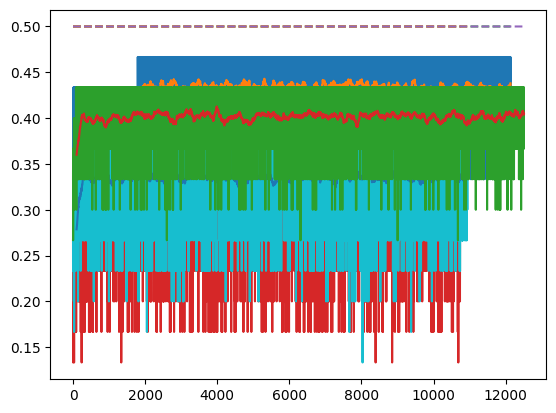

In [95]:
res = []

combinations = 0
for _, df in total_df.groupby('rest_name'):
    combinations += (df.shape[0] ** PEOPLES)

print(f'------- Searching space of size {combinations} -------\n')
for constraint in constraints:
    best_res = []
    best_fitness  = -np.inf
    best_solution = np.nan
    best_database = np.nan
    print('=' * 110, '\n')
    print('Running for constraints:')
    for meal in constraint:
        print_constraints(meal)
        print('-' * 110)
        
    print('\n', '=' * 110)


    for restaurant, database in groups:
        print(f' - Testing: {restaurant} combinations \n\t{database.shape[0]} possible dishes\n')
        database.reset_index(inplace=True, drop=True)
        res = []

        # choose run params:
        ga_instance = pygad.GA(num_generations         = 1024,
                               num_parents_mating      = 16,
                               sol_per_pop             = 32,
                               num_genes               = PEOPLES,

                               init_range_low          = 0,
                               init_range_high         = len(database),

                               random_mutation_min_val = 0,
                               random_mutation_max_val = len(database),

                               mutation_by_replacement = True,
                               mutation_num_genes      = 1,
                               mutation_probability    = 0.3,

                               gene_type               = int,
                               fitness_func            = fitness_function,
                               
                               on_generation=lambda t: print('.', end='')
                              )

        # run:
        ga_instance.run()

        # print solution:
        solution, fitness, i = ga_instance.best_solution()

        if fitness > best_fitness:
            best_fitness = fitness
            best_res = res.copy()
            best_solution = solution
            best_database = database.copy()
#         print(best_fitness)
    
    best_solution = [best_database.iloc[i] for i in best_solution]

    print(f'\n----------------- Best solution ------------------\n')
    print(f'Fitness:          {best_fitness}')
    print(f'Hard constraints: {"🏆" if best_fitness > 0.5 else "🛑"}')
    print(f'Total price:      {sum([dish["price"] for dish in best_solution])}') # ₪ (limit was {user_input["price"]} ₪)')
    print()
    [print_dish(best_solution, constraint, i) for i in range(len(best_solution))]

    print()
    print('Evolution Plot:')
    pd.Series(best_res).plot()
    pd.Series(best_res).rolling(window=100).mean().plot()
    pd.Series(np.ones(len(best_res)) * 0.5).plot(style='--')
